# Hybrid Model for one-day-ahead energy prediction:
Beginning from basis of **TOWT model**, then add new features from **Thermal mass** and **Autoregressive model**.

### Read data

In [1]:
import pandas as pd
import os
import numpy as np
from scipy import optimize

from sklearn.metrics import r2_score
from sklearn import ensemble
from sklearn.model_selection import RandomizedSearchCV

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
meta = pd.read_csv(r"D:\Temp\20190301\building-data-genome-project-v1\meta_open.csv", index_col='uid', parse_dates=["datastart","dataend"], dayfirst=True)
meta.head()

,dataend,datastart,energystarscore,heatingtype,industry,mainheatingtype,numberoffloors,occupants,primaryspaceusage,rating,sqft,sqm,subindustry,timezone,yearbuilt,nickname,primaryspaceuse_abbrev,newweatherfilename,annualschedule
uid,,,,,,,,,,,,,,,,,,,
Office_Abbey,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,Office,NaN,74180.0,6891.544540,College/University,America/Phoenix,1930,Abbey,Office,weather0.csv,schedule2.csv
Office_Abigail,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,Office,NaN,9703.0,901.437809,College/University,America/Phoenix,1940,Abigail,Office,weather0.csv,schedule2.csv
Office_Al,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,Office,NaN,118966.0,11052.298300,College/University,America/Phoenix,1988,Al,Office,weather0.csv,schedule2.csv
Office_Alannah,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,Office,NaN,10135.0,941.571905,College/University,America/Phoenix,NaN,Alannah,Office,weather0.csv,schedule2.csv
Office_Aliyah,2015-12-31 23:00:00,2015-01-01,NaN,NaN,Education,NaN,NaN,NaN,Office,NaN,202435.0,18806.818810,College/University,America/Phoenix,1967,Aliyah,Office,weather0.csv,schedule2.csv


In [3]:
data_elec = pd.read_csv(r"D:\Temp\20190301\building-data-genome-project-v1\temp_open_utc_complete.csv", index_col='timestamp', parse_dates=True).tz_convert('utc')
data_elec.head()

,Office_Cristina,PrimClass_Jolie,PrimClass_Jaylin,Office_Jesus,PrimClass_Uma,UnivClass_Tamra,PrimClass_Jayla,PrimClass_Janiya,PrimClass_Umar,PrimClass_Janice,...,Office_Emer,Office_Elena,Office_Emerald,Office_Ellis,Office_Elliot,Office_Eddie,Office_Georgia,UnivDorm_Lysander,PrimClass_Jazmin,PrimClass_Jenna
timestamp,,,,,,,,,,,,,,,,,,,,,
2010-01-01 08:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 09:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 10:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-01 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
singlebuilding = "Office_Benthe"

# Get Data
single_timezone = meta.T[singlebuilding].timezone
single_start = meta.T[singlebuilding].datastart
single_end = meta.T[singlebuilding].dataend
single_building_data = pd.DataFrame(data_elec[singlebuilding].tz_convert(single_timezone).truncate(before=single_start,after=single_end))             

# Get weather file
weatherfilename = meta.T[singlebuilding].newweatherfilename
print("Weatherfile: "+weatherfilename)
weather = pd.read_csv(os.path.join("D:/Temp/20190301/building-data-genome-project-v1/",weatherfilename),index_col='timestamp', parse_dates=True, na_values='-9999')
weather = weather.tz_localize(single_timezone, ambiguous = 'infer')
outdoor_temp = pd.DataFrame(weather[[col for col in weather.columns if 'Temperature' in col]]).resample("H").mean()
outdoor_temp = outdoor_temp.reindex(pd.DatetimeIndex(start=outdoor_temp.index[0], periods=len(single_building_data), freq="H")).fillna(method='ffill').fillna(method='bfill')

single_building_data = pd.concat([single_building_data, outdoor_temp], axis=1, join='inner')
single_building_data['hourofday'] = pd.Series(data=single_building_data.index.hour,index=single_building_data.index)
single_building_data['dayofweek'] = pd.Series(data=single_building_data.index.dayofweek,index=single_building_data.index)

single_building_data.rename(columns={singlebuilding: "elec_meas", "TemperatureC": "T_oa"},inplace=True)

single_building_data.dropna(inplace=True)          

single_building_data.head()


Weatherfile: weather7.csv


,elec_meas,T_oa,hourofday,dayofweek
2012-01-01 00:00:00-08:00,142.25,3.000000,0,6
2012-01-01 01:00:00-08:00,143.00,3.000000,1,6
2012-01-01 02:00:00-08:00,160.00,2.666667,2,6
2012-01-01 03:00:00-08:00,166.00,1.666667,3,6
2012-01-01 04:00:00-08:00,142.50,0.666667,4,6


### Electricity VS Outdoor Temperature (Weekday)

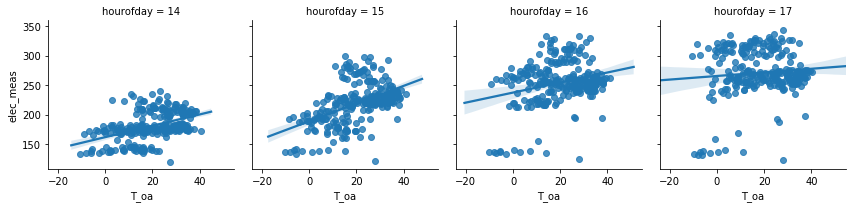

In [5]:
sns.lmplot(x="T_oa", y="elec_meas", 
           col="hourofday",
           data=single_building_data[single_building_data['dayofweek']<5][single_building_data['hourofday']>=14][single_building_data['hourofday']<=17], 
           height=3)

### Electricity VS Outdoor Temperature (Weekend)

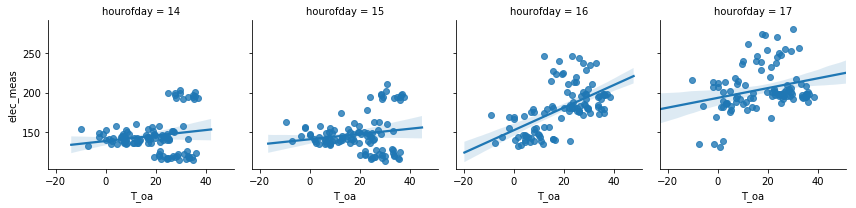

In [6]:
sns.lmplot(x="T_oa", y="elec_meas", 
           col="hourofday",
           data=single_building_data[single_building_data['dayofweek']>=5][single_building_data['hourofday']>=14][single_building_data['hourofday']<=17], 
           height=3)

# TOWT model
## regression model: GBM model

In [7]:
traindata = single_building_data[single_building_data.index.month.isin(["1","2","3","4","6","8","10","11","12"])]
testdata = single_building_data[single_building_data.index.month.isin(["5","7","9"])]

train_labels = np.array(traindata['elec_meas'].values)                
test_labels = np.array(testdata['elec_meas'].values)

train_features = traindata[['hourofday','dayofweek','T_oa']].values
test_features = testdata[['hourofday','dayofweek','T_oa']].values 

In [8]:
GBM_model = ensemble.GradientBoostingRegressor(n_estimators=500)
GBM_model.fit(train_features, train_labels)

# Use the forest's predict method on the train data
predictions = GBM_model.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
errors_mean = round(np.mean(errors), 2)

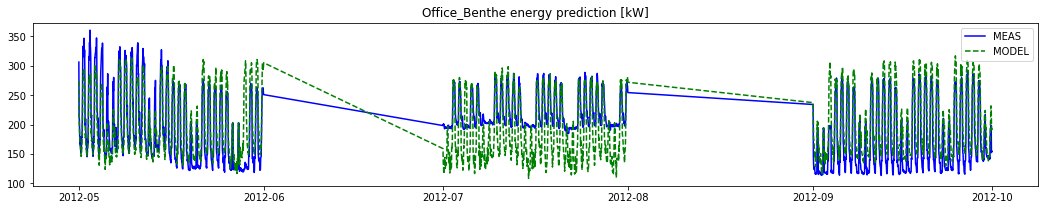

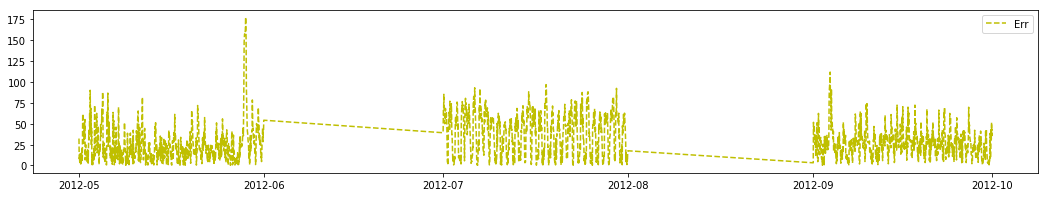

In [9]:
timestamp = testdata.index
plt.figure(figsize=(18,3))
plt.plot(timestamp, test_labels, '-b', label='MEAS')
plt.plot(timestamp, predictions, '--g', label='MODEL')
plt.title(singlebuilding+' energy prediction [kW]')
plt.legend(loc='upper right')
plt.show() 

plt.figure(figsize=(18,3))
plt.plot(timestamp, errors, '--y', label='Err')
plt.legend(loc='upper right')
plt.show() 

In [10]:
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(test_labels - predictions) / (pd.Series(test_labels).count() * np.mean(test_labels)))
CVRSME = 100 * ((sum((test_labels - predictions)**2) / (pd.Series(test_labels).count()-1))**(0.5)) / np.mean(test_labels)
RSQUARED = r2_score(test_labels, predictions)

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

MAPE: 16.65
NMBE: 1.09
CVRSME: 19.1
R SQUARED: 0.55


# Add: Thermal Mass
## through ewm

In [11]:
def objective(alphaValue):
    train_labels = np.array(single_building_data['elec_meas'].values)                
    train_features = single_building_data[['hourofday','dayofweek','T_oa']].values
    T_oa_ewm = pd.DataFrame(train_features[:,-1]).ewm(alpha=alphaValue).mean().values
    train_features = np.append(train_features,T_oa_ewm, axis=1)

    GBM_model = ensemble.GradientBoostingRegressor(n_estimators=500)
    GBM_model.fit(train_features, train_labels)

    # Use the forest's predict method on the train data
    predictions = GBM_model.predict(train_features)
    # Calculate the absolute errors
    errors = abs(predictions - train_labels)
    # Print out the mean absolute error (mae)
    errors_mean = round(np.mean(errors), 2)

    return errors_mean               

result = optimize.minimize_scalar(objective, bounds=(0.01,0.99), method='bounded', options={'xatol': 1e-03, 'maxiter': 500})
alphaValue = result.x
print('alpha: '+str(round(alphaValue,3)))

alpha: 0.01


In [12]:
single_building_data['T_oa_ewm'] = single_building_data['T_oa'].copy().ewm(alpha=alphaValue).mean()

single_building_data.head()

,elec_meas,T_oa,hourofday,dayofweek,T_oa_ewm
2012-01-01 00:00:00-08:00,142.25,3.000000,0,6,3.000000
2012-01-01 01:00:00-08:00,143.00,3.000000,1,6,3.000000
2012-01-01 02:00:00-08:00,160.00,2.666667,2,6,2.887721
2012-01-01 03:00:00-08:00,166.00,1.666667,3,6,2.577634
2012-01-01 04:00:00-08:00,142.50,0.666667,4,6,2.187376


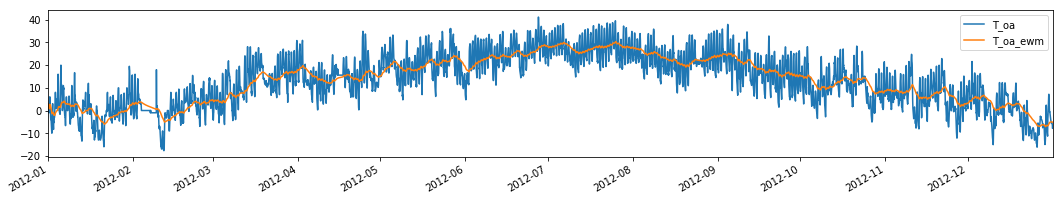

In [13]:
single_building_data[['T_oa','T_oa_ewm']].plot(figsize=(18,3))

### Electricity VS Outdoor Temperature (Weekday)

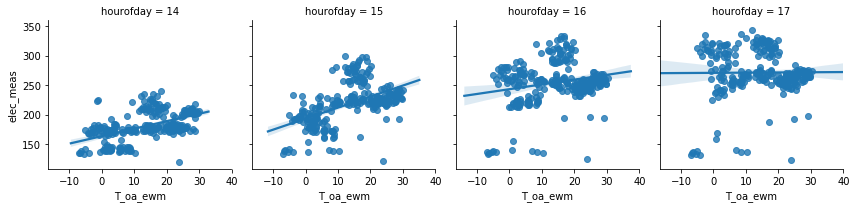

In [14]:
sns.lmplot(x="T_oa_ewm", y="elec_meas", 
           col="hourofday",
           data=single_building_data[single_building_data['dayofweek']<5][single_building_data['hourofday']>=14][single_building_data['hourofday']<=17], 
           height=3)

### Electricity VS Outdoor Temperature (Weekend)

Weekend:


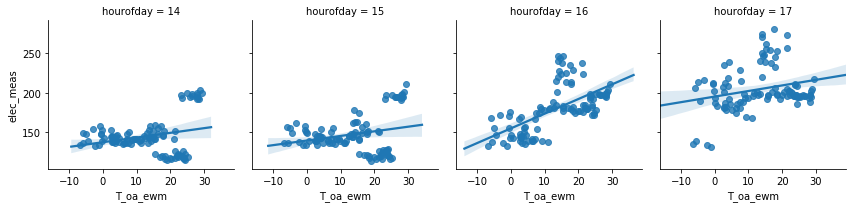

In [15]:
print('Weekend:')
sns.lmplot(x="T_oa_ewm", y="elec_meas", 
           col="hourofday",
           data=single_building_data[single_building_data['dayofweek']>=5][single_building_data['hourofday']>=14][single_building_data['hourofday']<=17], 
           height=3)

In [16]:
traindata = single_building_data[single_building_data.index.month.isin(["1","2","3","4","6","8","10","11","12"])]
testdata = single_building_data[single_building_data.index.month.isin(["5","7","9"])]

train_labels = np.array(traindata['elec_meas'].values)                
test_labels = np.array(testdata['elec_meas'].values)

train_features = traindata[['hourofday','dayofweek','T_oa','T_oa_ewm']].values
test_features = testdata[['hourofday','dayofweek','T_oa','T_oa_ewm']].values 

In [17]:
GBM_model = ensemble.GradientBoostingRegressor(n_estimators=500)
GBM_model.fit(train_features, train_labels)

# Use the forest's predict method on the train data
predictions = GBM_model.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
errors_mean = round(np.mean(errors), 2)

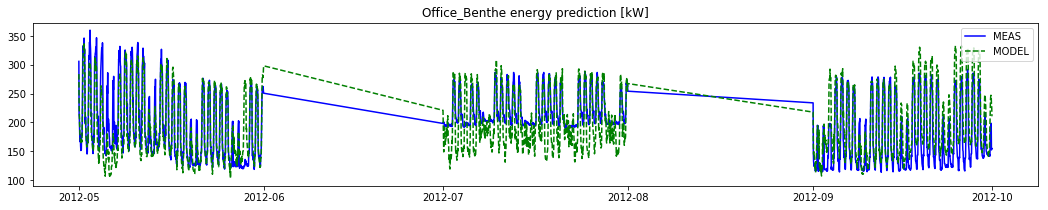

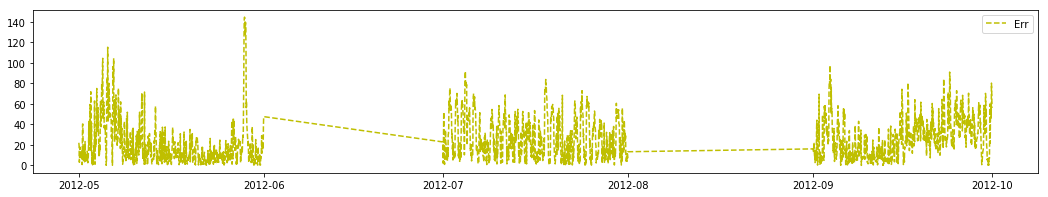

In [18]:
timestamp = testdata.index
plt.figure(figsize=(18,3))
plt.plot(timestamp, test_labels, '-b', label='MEAS')
plt.plot(timestamp, predictions, '--g', label='MODEL')
plt.title(singlebuilding+' energy prediction [kW]')
plt.legend(loc='upper right')
plt.show() 

plt.figure(figsize=(18,3))
plt.plot(timestamp, errors, '--y', label='Err')
plt.legend(loc='upper right')
plt.show() 

In [19]:
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(test_labels - predictions) / (pd.Series(test_labels).count() * np.mean(test_labels)))
CVRSME = 100 * ((sum((test_labels - predictions)**2) / (pd.Series(test_labels).count()-1))**(0.5)) / np.mean(test_labels)
RSQUARED = r2_score(test_labels, predictions)

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

MAPE: 13.58
NMBE: 0.71
CVRSME: 16.42
R SQUARED: 0.67


# Add: Auto Regressive

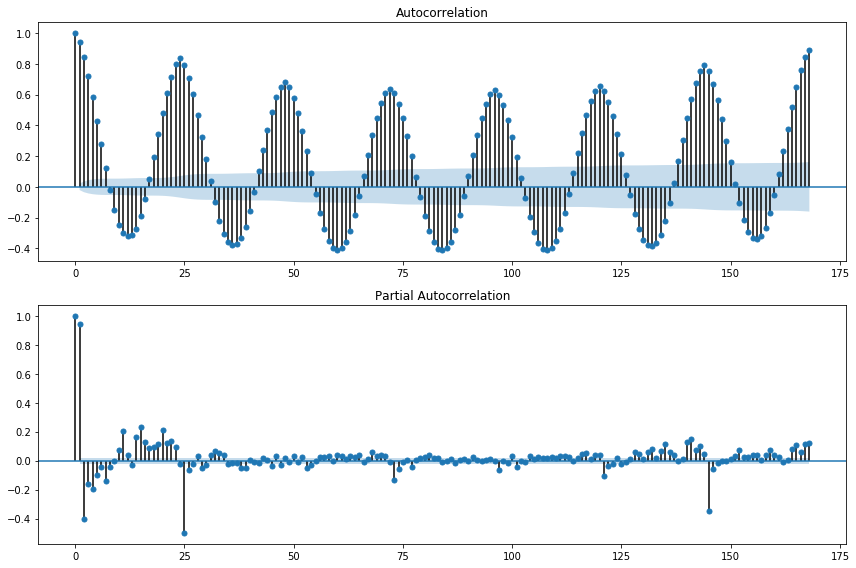

In [20]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(single_building_data['elec_meas'], lags=24*7, ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout();

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(single_building_data['elec_meas'], lags=24*7, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout();

In [21]:
single_building_data["elec_lastDay"] = single_building_data['elec_meas'].shift(24)
single_building_data.dropna(inplace=True)

single_building_data.head()

,elec_meas,T_oa,hourofday,dayofweek,T_oa_ewm,elec_lastDay
2012-01-02 00:00:00-08:00,221.5,-3.333333,0,0,1.132491,142.25
2012-01-02 01:00:00-08:00,220.5,-4.000000,1,0,0.908109,143.00
2012-01-02 02:00:00-08:00,220.0,-5.000000,2,0,0.658136,160.00
2012-01-02 03:00:00-08:00,213.0,-6.000000,3,0,0.385130,166.00
2012-01-02 04:00:00-08:00,219.5,-7.000000,4,0,0.091296,142.50


In [22]:
traindata = single_building_data[single_building_data.index.month.isin(["1","2","3","4","6","8","10","11","12"])]
testdata = single_building_data[single_building_data.index.month.isin(["5","7","9"])]

train_labels = np.array(traindata['elec_meas'].values)                
test_labels = np.array(testdata['elec_meas'].values)

train_features = traindata[['hourofday','dayofweek','T_oa','T_oa_ewm','elec_lastDay']].values
test_features = testdata[['hourofday','dayofweek','T_oa','T_oa_ewm','elec_lastDay']].values 

In [23]:
GBM_model = ensemble.GradientBoostingRegressor(n_estimators=500)
GBM_model.fit(train_features, train_labels)

# Use the forest's predict method on the train data
predictions = GBM_model.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
errors_mean = round(np.mean(errors), 2)

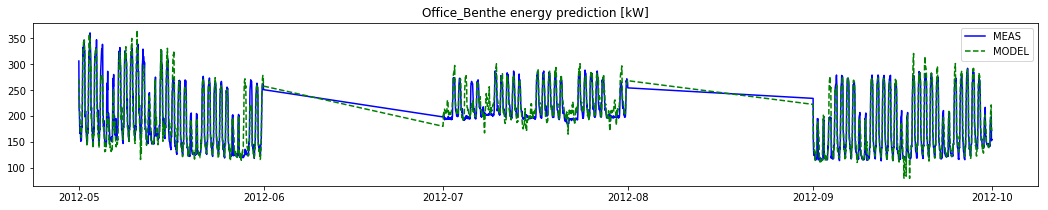

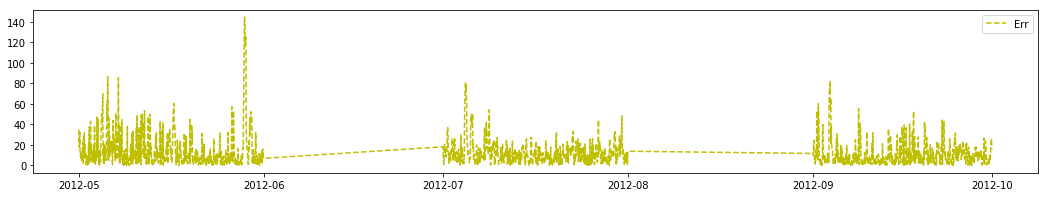

In [24]:
timestamp = testdata.index
plt.figure(figsize=(18,3))
plt.plot(timestamp, test_labels, '-b', label='MEAS')
plt.plot(timestamp, predictions, '--g', label='MODEL')
plt.title(singlebuilding+' energy prediction [kW]')
plt.legend(loc='upper right')
plt.show() 

plt.figure(figsize=(18,3))
plt.plot(timestamp, errors, '--y', label='Err')
plt.legend(loc='upper right')
plt.show() 

In [25]:
# Calculate mean absolute percentage error (MAPE) and add to list
MAPE = 100 * np.mean((errors / test_labels))
NMBE = 100 * (sum(test_labels - predictions) / (pd.Series(test_labels).count() * np.mean(test_labels)))
CVRSME = 100 * ((sum((test_labels - predictions)**2) / (pd.Series(test_labels).count()-1))**(0.5)) / np.mean(test_labels)
RSQUARED = r2_score(test_labels, predictions)

print("MAPE: "+str(round(MAPE,2)))
print("NMBE: "+str(round(NMBE,2)))
print("CVRSME: "+str(round(CVRSME,2)))
print("R SQUARED: "+str(round(RSQUARED,2)))

MAPE: 6.69
NMBE: -1.33
CVRSME: 9.6
R SQUARED: 0.89
